In [1]:
!python --version

Python 3.8.10


In [2]:
!nvidia-smi

Sat Dec  3 16:33:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:41:00.0 Off |                  N/A |
| 27%   29C    P8     8W / 250W |      0MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

In [3]:
import os
import numpy as np
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt
import tqdm

import torch 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

In [5]:
datapath = '../dataset/'
os.listdir(datapath)

['1.공인본', '2.삼성본', '3.대구개인본', '4.반야사']

In [6]:
# load image filepath
img_paths = {}
for subfile in os.listdir(datapath):
    subpath = datapath + subfile + '/'
    if subfile not in img_paths.keys():
        img_paths[subfile] = []
    for filename in os.listdir(subpath):
        if filename.startswith('.'): continue
        if not (filename.endswith('.jpg') or filename.endswith('.JPG')):continue
        img_paths[subfile].append(subpath+filename)
        
img_paths

{'1.공인본': ['../dataset/1.공인본/남명천화상송증도가_공인_2_019.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_018.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_020.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_023.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_024 (2).jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_024.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_029.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_001.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_025.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_002 (2).jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_030.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_002.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_026 (2).jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_003 (2).jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_031.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_003.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_032 (2).jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_004.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_026.jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_005 (2).jpg',
  '../dataset/1.공인본/남명천화상송증도가_공인_2_032 (3).jpg',
  '../dataset/1.공인

In [7]:
class MyDataset(Dataset):
    def __init__(self, imgpath):
        self.label_name = sorted(list(imgpath.keys()))
        self.label = []
        self.data_path = []
        
        for label in self.label_name:
            for path in imgpath[label]:
                self.label.append(self.label2index(label))
                self.data_path.append(path)

        self.data_tensor = []
        self.label_tensor = []

        for i in tqdm.tqdm(range(len(self.data_path))):
            datas, labels = self.get_item(i)
            self.data_tensor += datas
            self.label_tensor += labels
    
    def label2index(self, label):
        return self.label_name.index(label)

    def __len__(self):
        return len(self.data_tensor)

    def get_item(self, idx):
        img = Image.open(self.data_path[idx])
        w, h = img.size
        # if w and h > 1000, random crop w//1000 * h//1000 times
        img_crops, label_crops = [], []
        if w > 1000 and h > 1000:
            for i in range(w//1000):
                for j in range(h//1000):
                    img_crop = img.crop((i*1000, j*1000, (i+1)*1000, (j+1)*1000))
                    img_crop = img_crop.resize((224, 224))
                    img_crop = np.array(img_crop)
                    img_crop = img_crop.transpose(2, 0, 1)
                    img_crop = torch.from_numpy(img_crop).float()
                    label = torch.tensor(self.label[idx])
                    img_crops.append(img_crop)
                    label_crops.append(label)
        else:
            if w > h:
                img = img.crop((w//2 - h//2, 0, w//2 + h//2, h))
            elif w < h:
                img = img.crop((0, h//2 - w//2, w, h//2 + w//2))
            img = img.resize((224, 224))
            img = np.array(img)
            img = img.transpose(2, 0, 1)
            img = torch.from_numpy(img)
            label = torch.tensor(self.label[idx])
            img_crops.append(img)
            label_crops.append(label)
        return img_crops, label_crops

    def __getitem__(self, idx):
        return self.data_tensor[idx], self.label_tensor[idx]

In [8]:
# split dataset to train and test
# choose 80% data as train data from img_paths
train_img_paths = {}
for label in img_paths.keys():
    train_img_paths[label] = img_paths[label][:int(len(img_paths[label])*0.8)]

# choose 20% data as test data from img_paths
test_img_paths = {}
for label in img_paths.keys():
    test_img_paths[label] = img_paths[label][int(len(img_paths[label])*0.8):]

In [9]:
train_datast = MyDataset(train_img_paths)
train_datald = DataLoader(train_datast, batch_size=4, shuffle=True)

test_datast = MyDataset(test_img_paths)
test_datald = DataLoader(test_datast, batch_size=4, shuffle=False)

100%|██████████| 76/76 [08:54<00:00,  7.03s/it]


---

### pretrained model for classification

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, 4)

In [16]:
# use three channels, fine-tune backbone

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.0001, momentum=0.9)
results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

for epoch in range(10):
    running_loss = 0.0
    for i, (img, label) in enumerate(train_datald):
        img = img.to(device, torch.float)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        output = resnet50(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_datald)

    test_loss = 0.0

    with torch.no_grad():
        for i, (img, label) in enumerate(test_datald):
            img = img.to(device, torch.float)
            label = label.to(device)
            
            output = resnet50(img)
            _, pred = torch.max(output, 1)
            loss = criterion(output, label)
            test_loss += loss.item()
        test_loss /= len(test_datald)


    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    print('epoch: {}, train_loss: {:.6f}, test_loss: {:.6f}'.format(epoch+1, train_loss, test_loss))

epoch: 1, train_loss: 0.148172, test_loss: 1.424536
epoch: 2, train_loss: 0.085452, test_loss: 1.240307
epoch: 3, train_loss: 0.049550, test_loss: 1.093870
epoch: 4, train_loss: 0.030275, test_loss: 1.098135
epoch: 5, train_loss: 0.021695, test_loss: 1.065054
epoch: 6, train_loss: 0.017642, test_loss: 1.085235
epoch: 7, train_loss: 0.016152, test_loss: 1.154824
epoch: 8, train_loss: 0.013455, test_loss: 1.126639
epoch: 9, train_loss: 0.009392, test_loss: 1.079388
epoch: 10, train_loss: 0.007407, test_loss: 1.095530


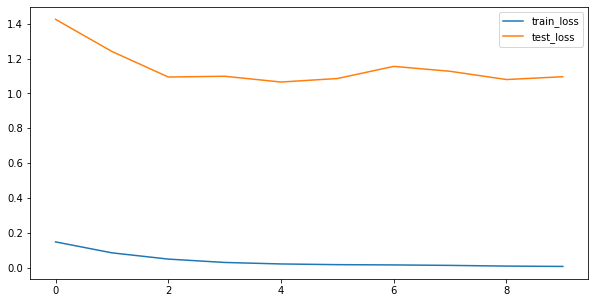

In [17]:
# plot loss and accuracy

plt.figure(figsize=(10, 5))
plt.plot(results['train_loss'], label='train_loss')
plt.plot(results['test_loss'], label='test_loss')
plt.legend()

In [18]:
# test accuracy

test_acc = 0.0
with torch.no_grad():
    for i, (img, label) in enumerate(test_datald):
        img = img.to(device, torch.float)
        label = label.to(device)
        
        output = resnet50(img)
        _, pred = torch.max(output, 1)
        test_acc += torch.sum(pred == label).item()
test_acc /= len(test_datast)
print('test_acc: {:.4f}'.format(test_acc))

test_acc: 0.8506


### directly train a model

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 4)

# use three channels, fine-tune backbone

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

for epoch in range(10):
    running_loss = 0.0
    for i, (img, label) in enumerate(train_datald):
        img = img.to(device, torch.float)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_datald)

    test_loss = 0.0

    with torch.no_grad():
        for i, (img, label) in enumerate(test_datald):
            img = img.to(device, torch.float)
            label = label.to(device)
            
            output = model(img)
            _, pred = torch.max(output, 1)
            loss = criterion(output, label)
            test_loss += loss.item()
        test_loss /= len(test_datald)


    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    print('epoch: {}, train_loss: {:.6f}, test_loss: {:.6f}'.format(epoch+1, train_loss, test_loss))

epoch: 1, train_loss: 0.731745, test_loss: 1.615837
epoch: 2, train_loss: 0.435753, test_loss: 1.910770
epoch: 5, train_loss: 0.284896, test_loss: 1.720862
epoch: 6, train_loss: 0.251058, test_loss: 1.660606
epoch: 7, train_loss: 0.218157, test_loss: 1.636581
epoch: 8, train_loss: 0.203586, test_loss: 1.532230
epoch: 9, train_loss: 0.171625, test_loss: 1.668536
epoch: 10, train_loss: 0.155043, test_loss: 1.677320


In [ ]:
# test accuracy

test_acc = 0.0
with torch.no_grad():
    for i, (img, label) in enumerate(test_datald):
        img = img.to(device, torch.float)
        label = label.to(device)
        
        output = model(img)
        _, pred = torch.max(output, 1)
        test_acc += torch.sum(pred == label).item()
test_acc /= len(test_datast)
print('test_acc: {:.4f}'.format(test_acc))

test_acc: 0.6336


### explain model

In [260]:
# use lime to explain the result

import lime
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()

def predict_fn(img):
    img = img.transpose(0, 3, 1, 2)
    img = torch.from_numpy(img).float()
    img = img.to(device, torch.float)
    output = resnet50(img)
    probs = torch.softmax(output, dim=1)
    return probs.cpu().detach().numpy()


index = 1
flag = False
for i, (imgs, label) in enumerate(test_datald):
    if label[0] == index: flag = True
    imgs = imgs.to(device, torch.float)
    label = label.to(device)
    if flag: break

tensor([1, 1, 1, 1], device='cuda:0')

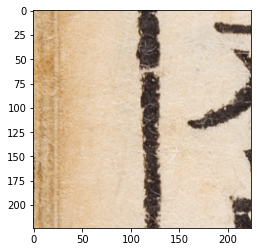

In [261]:
img = imgs[1].cpu().detach().numpy()
img = img.transpose(1, 2, 0)

plt.imshow(img/255)
label

In [262]:
explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

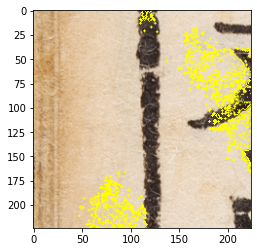

In [263]:
# get the most important region with the img as background
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 255, mask))

In [264]:
# get the pred label of img
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).float().cuda()
output = resnet50(img.unsqueeze(0))
_, pred = torch.max(output, 1)
pred, label[0]

(tensor([1], device='cuda:0'), tensor(1, device='cuda:0'))